In [75]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from dotenv import load_dotenv
import pandas as pd
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

load_dotenv()

PROJECT_DIR = os.getenv("PROJECT_DIR")
metadata_df = pd.read_csv(f"{PROJECT_DIR}/crawled_leaflets/metadata.csv")
model_dir = os.path.join(PROJECT_DIR, "models")
model_path = os.path.join(model_dir, "polygon_pred", "train4", "weights", "best.pt")

In [76]:
model = YOLO(model_path)

In [77]:
np.random.seed(42)
rnd_leaflet = metadata_df.sample(1, random_state=44).iloc[0]
rnd_leaflet_path = f"{PROJECT_DIR}/crawled_leaflets/{rnd_leaflet['supermarket_name']}/{rnd_leaflet['leaflet_id']}"
imgs = [os.path.join(rnd_leaflet_path, i) for i in os.listdir(rnd_leaflet_path)]
rnd_img = np.random.choice(imgs)

# Deal Extraction (Do not modify!)

In [78]:
def resize_image(img, target_size):
    # Resize the pillow image to the target size
    return img.resize(target_size).convert("RGB")

In [79]:
def extract_bbox(box, names, orig_shape, conf):
    _class = names[int(box.cls)]
    x_center, y_center, width, height = box.xywhn[0]
    pixel_x = (x_center - width / 2) * 100
    pixel_y = (y_center - height / 2) * 100
    pixel_width = width * 100
    pixel_height = height * 100

    return {
        "original_width": int(orig_shape[1]),
        "original_height": int(orig_shape[0]),
        "image_rotation": 0,
        "value": {
            "x": float(pixel_x),
            "y": float(pixel_y),
            "width": float(pixel_width),
            "height": float(pixel_height),
            "rotation": 0,
            "rectanglelabels": [_class],
        },
        "from_name": "class",
        "to_name": "image",
        "type": "rectanglelabels",
        "score": float(conf),
    }


def extract_polygon(xyn, names, orig_shape, conf, class_index):
    _class = names[class_index]

    if xyn is None or len(xyn) == 0:
        return None

    # Convert coordinates to relative values (0-100%)
    contour = xyn * 100

    return {
        "original_width": int(orig_shape[1]),
        "original_height": int(orig_shape[0]),
        "image_rotation": 0,
        "value": {"points": contour.tolist(), "polygonlabels": [_class]},
        "from_name": "label",
        "to_name": "image",
        "type": "polygonlabels",
        "score": float(conf),
    }


def process_image(yolo, image_path):
    bbox_annotation = []
    polygon_annotation = []
    results = yolo(image_path)[0]
    names = results.names
    boxes = results.boxes
    masks = results.masks
    orig_shape = results.orig_shape

    for i, box in enumerate(boxes):
        conf = float(box.conf)
        if conf < 0.35:
            continue

        bbox_pred = extract_bbox(box, names, orig_shape, conf)
        bbox_annotation.append(bbox_pred)

        if masks is not None and i < len(masks):
            xyn = masks.xyn[i]
            polygon_pred = extract_polygon(xyn, names, orig_shape, conf, int(box.cls))
            if polygon_pred:
                polygon_annotation.append(polygon_pred)

    return bbox_annotation, polygon_annotation

In [80]:
_, polygon_annotation = process_image(model, rnd_img)


image 1/1 F:\OneDrive\toShare\Gabrilyi\leaflet_project\crawled_leaflets\kaufland\2436681\kaufland_2436681_15.jpg: 640x544 15 Deals, 36.5ms
Speed: 3.3ms preprocess, 36.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


In [89]:
import cv2
import numpy as np
from PIL import Image
import os


def recalculate_points(points, orig_shape):
    orig_height, orig_width = orig_shape
    new_points = []
    for p in points:
        x, y = p
        new_x = (x / 100) * orig_width
        new_y = (y / 100) * orig_height
        new_points.append([new_x, new_y])

    return new_points


def process_polygons(polygon_annotation, img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_for_cutout = deepcopy(img_rgb)
    cutout_images = []

    for polygon in polygon_annotation:
        label = polygon["value"]["polygonlabels"][0]
        points = polygon["value"]["points"]

        # Recalculate points based on original image dimensions
        points = recalculate_points(points, (polygon["original_height"], polygon["original_width"]))
        points_array = np.array(points, dtype=np.int32)
        points_array = points_array.reshape((-1, 1, 2))

        # Create a mask for the polygon
        mask = np.zeros(img_for_cutout.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [points_array], 255)

        # Extract the polygon region
        polygon_region = cv2.bitwise_and(img_for_cutout, img_for_cutout, mask=mask)

        # Find bounding box of the polygon
        x_coords = [int(p[0]) for p in points]
        y_coords = [int(p[1]) for p in points]

        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        # Create transparent cutout
        cutout = np.zeros((y_max - y_min + 1, x_max - x_min + 1, 4), dtype=np.uint8)
        cutout[:, :, :3] = polygon_region[y_min : y_max + 1, x_min : x_max + 1]
        cutout[:, :, 3] = mask[y_min : y_max + 1, x_min : x_max + 1]

        # Draw polygon on the original image
        cv2.polylines(img_rgb, [points_array], isClosed=True, color=(0, 0, 255), thickness=2)
        cv2.putText(
            img_rgb,
            label,
            (points_array[0][0][0], points_array[0][0][1]),
            cv2.FONT_HERSHEY_SIMPLEX,
            2,
            (0, 0, 255),
            3,
        )

        # Convert cutout to PIL Image with transparency
        cutout_pil = Image.fromarray(cutout, "RGBA")
        cutout_images.append({"image": cutout_pil, "label": label})

    # Convert annotated image to PIL Image
    annotated_image = Image.fromarray(img_rgb)

    return annotated_image, cutout_images

In [90]:
annotated_image, cutout_images = process_polygons(polygon_annotation, rnd_img)

# Deal Processing (Modify!)

Example Usage...
In `annotated_image` the full, original image is saved with all polygons drawn on it with the corresponding labels.
In `cutout_images` the individual polygons are saved as separate images with the corresponding labels in a dictionary.

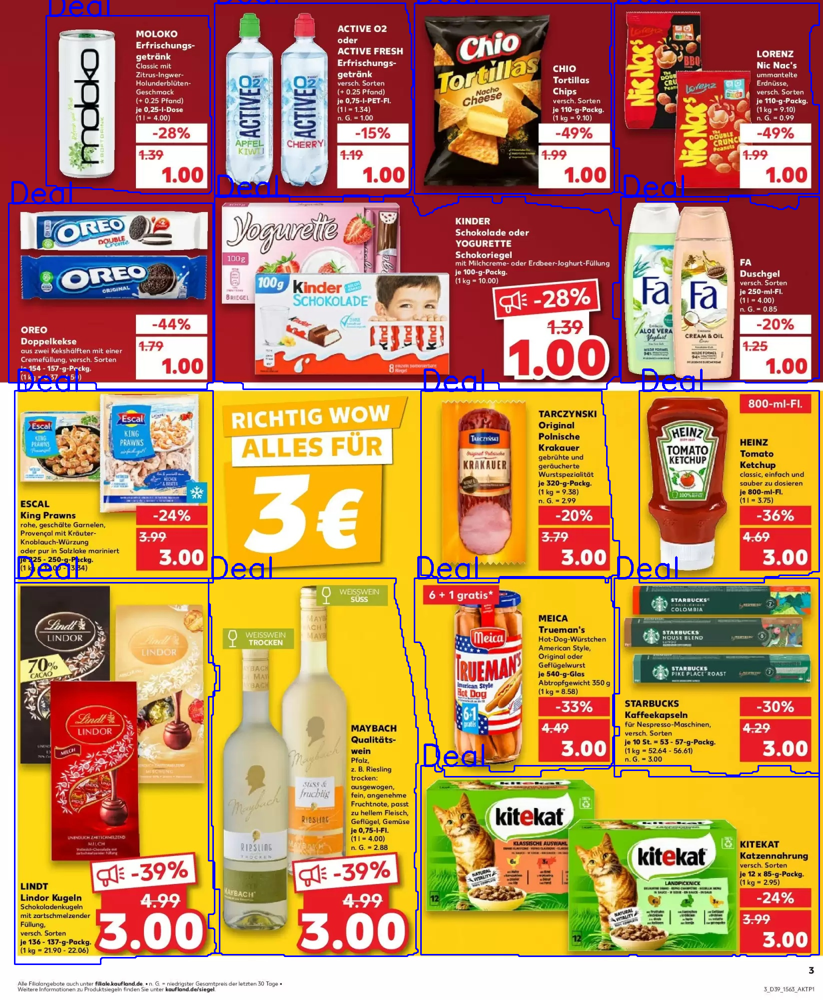

In [91]:
resize_image(annotated_image, (int(annotated_image.width / 2), int(annotated_image.height / 2)))

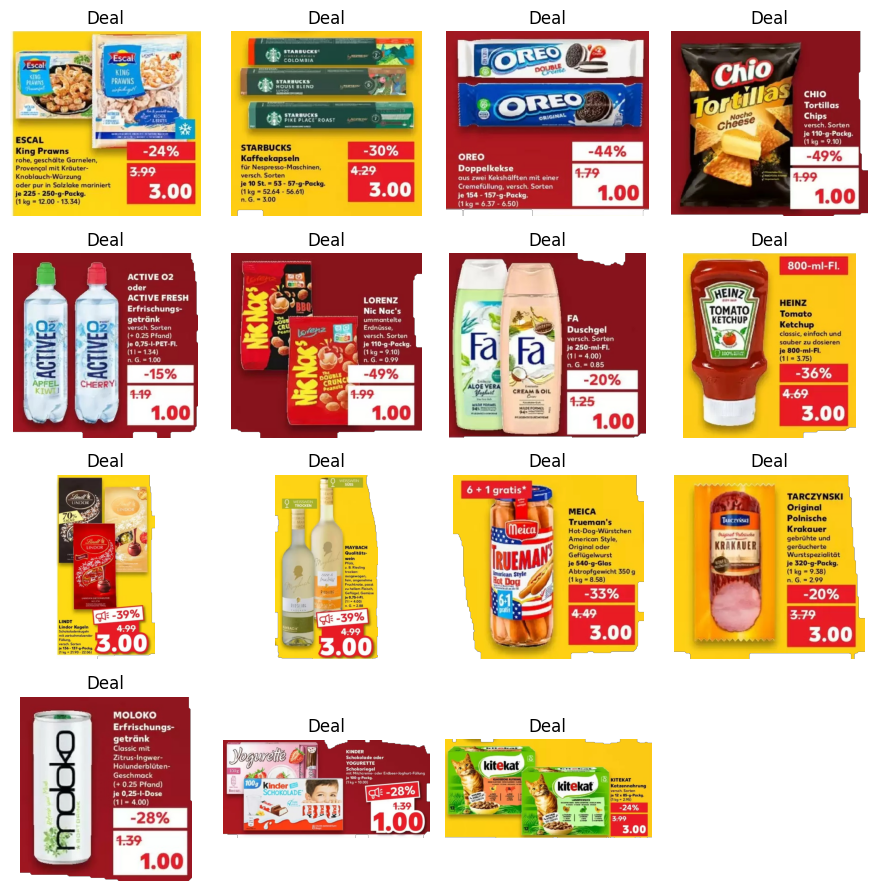

In [92]:
n_cols = 4
n_rows = len(cutout_images) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(9, 9))

for i, cutout in enumerate(cutout_images):
    ax = axs[i // n_cols, i % n_cols]
    ax.imshow(cutout["image"])
    ax.set_title(cutout["label"])
    ax.axis("off")

for i in range(len(cutout_images), n_cols * n_rows):
    axs[i // n_cols, i % n_cols].axis("off")

plt.tight_layout()
plt.show()